In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRFClassifier
import lightgbm
import seaborn as sns
import os
from timeit import timeit

# 1. Load data
Load twitter data

In [2]:
data = pd.read_csv(
    os.path.join(os.environ['HOME'], 'data', 'tweets', 'training.1600000.processed.noemoticon.csv'),
    header=None, usecols=[0,2,4,5], names=['sentiment','date','user','text'],
    parse_dates=['date'])
data.dtypes

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


sentiment             int64
date         datetime64[ns]
user                 object
text                 object
dtype: object

In [3]:
len(data)

1600000

In [4]:
twt = pd.concat([
    data[data['sentiment']==0].sample(n=100000),
    data[data['sentiment']==4].sample(n=100000)])

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

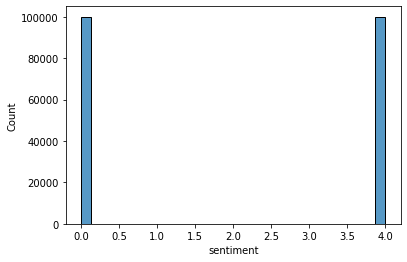

In [5]:
sns.histplot(twt.sentiment)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(twt, test_size=0.3)

In [8]:
len(train), len(test)

(140000, 60000)

# 2. Feature Engineering
- Encode text features (TFIDF)
- Encode datetime features

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer # for letter n-gram

## Text features

In [10]:
tfidf = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))
letterngram = CountVectorizer(analyzer='char_wb', ngram_range=(2,4))

In [11]:
tfidf = tfidf.fit(train['text'])
letterngram = letterngram.fit(train['text'])

In [12]:
feat_tfidf = tfidf.transform(train.loc[:,'text'])
feat_letterngram = letterngram.transform(train['text'])

In [13]:
feat_tfidf.shape, feat_letterngram.shape

((140000, 725864), (140000, 287630))

In [14]:
type(feat_tfidf)

scipy.sparse.csr.csr_matrix

In [15]:
feat_tfidf_test = tfidf.transform(test.loc[:,'text'])
feat_letterngram_test = letterngram.transform(test['text'])

# 3. Basic Models
Base without feature selection or regularisation

In [16]:
labels = train['sentiment']
labels_test = test['sentiment']

In [17]:
from sklearn.ensemble import RandomForestClassifier

## Random Forest
Limit max depth so they're not too overfitted

In [18]:
rf_tfidf = RandomForestClassifier(
    n_estimators=100, criterion='gini',
    max_depth=4,
    bootstrap=True, min_samples_leaf=10)
rf_letterngram = RandomForestClassifier(
    n_estimators=100, criterion='gini',
    max_depth=4,
    bootstrap=True, min_samples_leaf=10)

In [19]:
rf_tfidf.fit(feat_tfidf, labels)
rf_letterngram.fit(feat_letterngram, labels)

RandomForestClassifier(max_depth=4, min_samples_leaf=10)

In [20]:
feat_tfidf.shape, feat_tfidf_test.shape

((140000, 725864), (60000, 725864))

In [21]:
pred_rf_tfidf = rf_tfidf.predict(feat_tfidf_test)
pred_rf_letterngram = rf_letterngram.predict(feat_letterngram_test)

ppred_rf_tfidf = rf_tfidf.predict_proba(feat_tfidf_test)
ppred_rf_letterngram = rf_letterngram.predict_proba(feat_letterngram_test)

In [22]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [23]:
print('TFIDF + RandomForest')
for lbl in [0,4]:
    pc = precision_score(labels_test, pred_rf_tfidf, pos_label=lbl)
    rc = recall_score(labels_test, pred_rf_tfidf, pos_label=lbl)
    print(f'Class = {lbl} : Precision = {pc:.3f}, Recall = {rc:.3f}')
auc = roc_auc_score(labels_test, ppred_rf_tfidf[:,1], labels=[0,4])
print(f'AUC = {auc:.3f}')

TFIDF + RandomForest
Class = 0 : Precision = 0.754, Recall = 0.345
Class = 4 : Precision = 0.573, Recall = 0.887
AUC = 0.685


In [24]:
print('Letter-n-gram + RandomForest')
for lbl in [0,4]:
    pc = precision_score(labels_test, pred_rf_letterngram, pos_label=lbl)
    rc = recall_score(labels_test, pred_rf_letterngram, pos_label=lbl)
    print(f'Class = {lbl} : Precision = {pc:.3f}, Recall = {rc:.3f}')
auc = roc_auc_score(labels_test, ppred_rf_letterngram[:,1], labels=[0,4])
print(f'AUC = {auc:.3f}')

Letter-n-gram + RandomForest
Class = 0 : Precision = 0.707, Recall = 0.674
Class = 4 : Precision = 0.686, Recall = 0.718
AUC = 0.762


## XGBoost
Limit overfitting with regularisation

In [25]:
params = {
    'use_label_encoder': False,
    'objective': 'binary:logistic',
    'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01,
    'reg_lambda': 0.1 # L2 regularisation
}

In [26]:
# XGB requires labels to start from [0,1,..,NCLASS-1]
labels_xgb = labels/4
labels_xgb_test = labels_test/4

In [27]:
xgb_tfidf = XGBRFClassifier(**params)
xgb_tfidf.fit(feat_tfidf, labels_xgb)

[14:58:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.01,
                max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=8,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
                tree_method='exact', use_label_encoder=False,
                validate_parameters=1, verbosity=None)

In [28]:
xgb_letterngram = XGBRFClassifier(**params)
xgb_letterngram.fit(feat_letterngram, labels_xgb)

[14:59:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.01,
                max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=8,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
                tree_method='exact', use_label_encoder=False,
                validate_parameters=1, verbosity=None)

In [29]:
pred_xgb_tfidf = xgb_tfidf.predict(feat_tfidf_test) * 4
pred_xgb_letterngram = xgb_letterngram.predict(feat_letterngram_test) * 4

ppred_xgb_tfidf = xgb_tfidf.predict_proba(feat_tfidf_test) * 4
ppred_xgb_letterngram = xgb_letterngram.predict_proba(feat_letterngram_test) * 4

In [30]:
print('TFIDF + XGBoost')
for lbl in [0,4]:
    pc = precision_score(labels_test, pred_xgb_tfidf, pos_label=lbl)
    rc = recall_score(labels_test, pred_xgb_tfidf, pos_label=lbl)
    print(f'Class = {lbl} : Precision = {pc:.3f}, Recall = {rc:.3f}')
auc = roc_auc_score(labels_test, ppred_rf_tfidf[:,1], labels=[0,4])
print(f'AUC = {auc:.3f}')

TFIDF + XGBoost
Class = 0 : Precision = 0.801, Recall = 0.138
Class = 4 : Precision = 0.526, Recall = 0.965
AUC = 0.685


In [31]:
print('Letter-n-gram + XGBoost')
for lbl in [0,4]:
    pc = precision_score(labels_test, pred_xgb_letterngram, pos_label=lbl)
    rc = recall_score(labels_test, pred_xgb_letterngram, pos_label=lbl)
    print(f'Class = {lbl} : Precision = {pc:.3f}, Recall = {rc:.3f}')
auc = roc_auc_score(labels_test, ppred_rf_tfidf[:,1], labels=[0,4])
print(f'AUC = {auc:.3f}')

Letter-n-gram + XGBoost
Class = 0 : Precision = 0.626, Recall = 0.746
Class = 4 : Precision = 0.682, Recall = 0.551
AUC = 0.685


## Leaky ReLu

In [32]:
x = np.arange(-30, 5, 0.5)
y1 = [w*0.01 if w<0 else w for w in x]
y2 = [w*0.025 if w<0 else w for w in x]

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

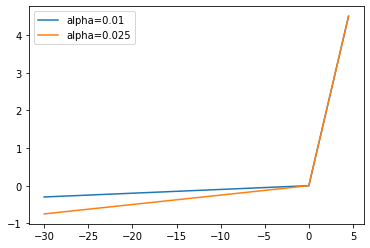

In [33]:
sns.lineplot(x, y1, label='alpha=0.01')
sns.lineplot(x, y2, label='alpha=0.025')

## LightGBM

A Microsoft's speedy gradient boosted tree

In [34]:
lgb_tfidf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=20,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=50,
    n_jobs=2)
lgb_tfidf.fit(feat_tfidf, labels)

LGBMClassifier(max_depth=3, n_estimators=50, n_jobs=2, num_leaves=20)

In [35]:
lgb_letterngram = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=20,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=50,
    n_jobs=2)
lgb_letterngram.fit(feat_letterngram.astype('float32'), labels)

LGBMClassifier(max_depth=3, n_estimators=50, n_jobs=2, num_leaves=20)

Validate models

In [36]:
pred_lgb_tfidf = lgb_tfidf.predict(feat_tfidf_test)
pred_lgb_letterngram = lgb_letterngram.predict(feat_letterngram_test.astype('float32'))

In [37]:
print('TFIDF + LightGBM')
for lbl in [0,4]:
    pc = precision_score(labels_test, pred_lgb_tfidf, pos_label=lbl)
    rc = recall_score(labels_test, pred_lgb_tfidf, pos_label=lbl)
    print(f'Class = {lbl} : Precision = {pc:.3f}, Recall = {rc:.3f}')
auc = roc_auc_score(labels_test, pred_lgb_tfidf, labels=[0,4])
print(f'AUC = {auc:.3f}')

TFIDF + LightGBM
Class = 0 : Precision = 0.794, Recall = 0.370
Class = 4 : Precision = 0.587, Recall = 0.903
AUC = 0.636


In [38]:
print('Letter-ngram + LightGBM')
for lbl in [0,4]:
    pc = precision_score(labels_test, pred_lgb_letterngram, pos_label=lbl)
    rc = recall_score(labels_test, pred_lgb_letterngram, pos_label=lbl)
    print(f'Class = {lbl} : Precision = {pc:.3f}, Recall = {rc:.3f}')
auc = roc_auc_score(labels_test, pred_lgb_letterngram, labels=[0,4])
print(f'AUC = {auc:.3f}')

Letter-ngram + LightGBM
Class = 0 : Precision = 0.692, Recall = 0.721
Class = 4 : Precision = 0.706, Recall = 0.676
AUC = 0.698


# 3. BERT based models

Try variants of transformers

In [39]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow import keras

Load pretrained BERT models

In [40]:
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
mbert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Allow BERT layers training during fine-tuning step

In [41]:
mbert.trainable = True

In [42]:
mbert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


Encode tweet dataset

In [43]:
def tokenise(text): # tokenise str and convert to token IDs
    words = ['[CLS]'] + tokeniser.tokenize(text) + ['[SEP]']
    return tokeniser.convert_tokens_to_ids(words)

def create_mask(enctext):
    return [1]*len(enctext)

In [44]:
enc_train = train['text'].apply(tokenise)
mask_train = enc_train.map(create_mask)

In [45]:
enc_test = test['text'].apply(tokenise)
mask_test = enc_test.map(create_mask)

In [46]:
enc_train[:5].map(tf.shape) # Shape of each ID vector is different, need padding

691306     (tf.Tensor(16, shape=(), dtype=int32))
466096     (tf.Tensor(34, shape=(), dtype=int32))
899887     (tf.Tensor(13, shape=(), dtype=int32))
1459096    (tf.Tensor(14, shape=(), dtype=int32))
40321      (tf.Tensor(31, shape=(), dtype=int32))
Name: text, dtype: object

Find out max length of sequence

In [47]:
max(enc_train.map(len))

156

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='text', ylabel='Count'>

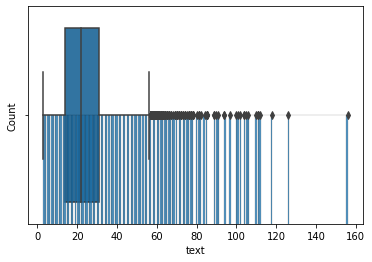

In [48]:
lt = enc_train.map(len)
sns.histplot(lt)
sns.boxplot(lt)

Padd all IDs

In [49]:
MAX_LEN = max(enc_train.map(len)) + 2 # plus CLS+SEP

def pad(seq):
    return seq + [0]*(MAX_LEN - len(seq))

In [50]:
enc_train = enc_train.apply(pad)
mask_train = mask_train.apply(pad)

In [51]:
# Filter test set, excessive lengths go away
enc_test[enc_test.map(len)<MAX_LEN-2]
mask_test[mask_test.map(len)<MAX_LEN-2]

enc_test = enc_test.apply(pad)
mask_test = mask_test.apply(pad)

Build classification model from BERT

In [52]:
linput = keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32, name="inputs")
mask = keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32, name="attention_mask")
ttypes = keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32, name="token_types")

output = mbert(linput, attention_mask=mask, token_type_ids=ttypes)

logit = keras.layers.Dense(128, name="fc1")(output[1]) # pooled output of BERT
logit = keras.layers.Dense(64, activation='relu', name='relu')(logit) 
logit = keras.layers.Dropout(0.2, name='dropout')(logit)

lg = keras.regularizers.L2(0.1)
logit = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=lg)(logit)

# Model
model = keras.models.Model(inputs=[linput,mask,ttypes], outputs=[logit], name='BERT')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [53]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-3), # low learning rate to suit BERT
    metrics=[keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)])

In [54]:
#model.summary()

Prepare tensor dataset

In [71]:
# Make numpy ndarray out of "series" of "list"
dtrain = np.array(list(map(np.array, enc_train)))
dtest = np.array(list(map(np.array, enc_test)))

dmask = np.array(list(map(np.array, mask_train)))
dmasktest = np.array(list(map(np.array, mask_test)))

dtype = dmask.copy()
dtypetest = dmasktest.copy()

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [72]:
# dtrain = tf.convert_to_tensor(enc_train.values.tolist())
# dtest = tf.convert_to_tensor(enc_test.values.tolist())

# dmask = tf.convert_to_tensor(mask_train.values.tolist())
# dmasktest = tf.convert_to_tensor(mask_test.values.tolist())

# dtype = tf.convert_to_tensor(mask_train[:].values.tolist())
# dtypetest = tf.convert_to_tensor(mask_test[:].values.tolist())

In [73]:
dlabels = (labels.astype('float32')/4).values
dlabeltest = (labels_test.astype('float32')/4).values

In [74]:
dtrain.dtype, dmask.dtype, dtype.dtype

(dtype('int64'), dtype('int64'), dtype('int64'))

In [75]:
dtrain.shape, dmask.shape, dtype.shape

((140000, 158), (140000, 158), (140000, 158))

In [76]:
model.fit([dtrain, dmask, dtype], dlabels,
         validation_data=([dtest, dmasktest, dtypetest], dlabeltest),
         batch_size=32,
         epochs=5)

Epoch 1/5
 176/4375 [>.............................] - ETA: 26:09:04 - loss: 1.0305 - accuracy: 0.5006

KeyboardInterrupt: 